In [36]:
import pybamm as pb
import numpy as np
import matplotlib.pyplot as plt
from func_project import *

In [37]:
"""
    Pre-simulation settings
"""
# fetch parameter values
old = pb.ParameterValues("Chen2020_composite")
parameters = update_parameter_set(old)

# Adding plating parameters to the parameter set
parameters.update(
    {
        
        # Plating parameters referred from OKane2022
        "Lithium metal partial molar volume [m3.mol-1]": 1.3e-05,
        "Primary: Lithium plating kinetic rate constant [m.s-1]": 1e-09,
        "Primary: Exchange-current density for plating [A.m-2]"
        "": graphite_plating_exchange_current_density_OKane2020,
        "Primary: Exchange-current density for stripping [A.m-2]"
        "": graphite_stripping_exchange_current_density_OKane2020,
        "Primary: Initial plated lithium concentration [mol.m-3]": 0.0,
        "Primary: Typical plated lithium concentration [mol.m-3]": 1000.0,
        "Primary: Lithium plating transfer coefficient": 0.65,
        "Primary: Dead lithium decay constant [s-1]": 1e-06,
        "Primary: Dead lithium decay rate [s-1]"
        "": graphite_SEI_limited_dead_lithium_OKane2022,
        "Secondary: Lithium plating kinetic rate constant [m.s-1]": 1e-09,
        "Secondary: Exchange-current density for plating [A.m-2]"
        "": silicon_plating_exchange_current_density_OKane2020,
        "Secondary: Exchange-current density for stripping [A.m-2]"
        "": silicon_stripping_exchange_current_density_OKane2020,
        "Secondary: Initial plated lithium concentration [mol.m-3]": 0.0,
        "Secondary: Typical plated lithium concentration [mol.m-3]": 1000.0,
        "Secondary: Lithium plating transfer coefficient": 0.65,
        "Secondary: Dead lithium decay constant [s-1]": 1e-06,
        "Secondary: Dead lithium decay rate [s-1]"
        "": silicon_SEI_limited_dead_lithium_OKane2022,
        "Lithium plating transfer coefficient": 0.5,
        "Dead lithium decay constant [s-1]": 1e-4,
        

        # Parameters for primary/secondary phases in the composite
        'Primary: SEI lithium ion conductivity [S.m-1]': 1.0e-7,
        'Secondary: SEI lithium ion conductivity [S.m-1]': 1.0e-7,        
        "Primary: Tunneling distance for electrons [m]": 0,
        "Secondary: Tunneling distance for electrons [m]": 0,

        "Primary: Initial inner SEI thickness [m]": 1e-12,
        "Secondary: Initial inner SEI thickness [m]": 5e-09,
        "Primary: Initial outer SEI thickness [m]": 5e-09,
        "Secondary: Initial outer SEI thickness [m]": 5e-09,

        'Primary: Negative electrode density [kg.m-3]': 1657.0,
        'Secondary: Negative electrode density [kg.m-3]': 2650.0,

        "Positive electrode OCP [V]": nmc_LGM50_ocp_Chen2020,

        "Negative electrode density [kg.m-3]": (0.9*1657 + 0.1*2560),

        "Primary: Maximum concentration in negative electrode [mol.m-3]": 28700,
        "Primary: Initial concentration in negative electrode [mol.m-3]": 23000,
        "Primary: Negative particle diffusivity [m2.s-1]": 5.5e-14,
        "Secondary: Negative particle diffusivity [m2.s-1]": 1.67e-14,
        "Secondary: Initial concentration in negative electrode [mol.m-3]": 277000,
        "Secondary: Maximum concentration in negative electrode [mol.m-3]": 278000,

        # particle radius
        #"Primary: Positive particle radius [m]": ,

    }, check_already_exists=False,
)

# write the parameter values and model variables to a text file
f = open("parameter_values.txt", "w")
f.write(f"{parameters}")
f.close()

# mesh settings
var_pts = {"x_n": 20, "x_s": 20, "x_p": 20, "r_n": 40, "r_p": 40}
submesh_types = pb.lithium_ion.DFN().default_submesh_types
submesh_types["negative particle"] = pb.MeshGenerator(
    pb.Exponential1DSubMesh, submesh_params={"side": "right"}
)
submesh_types["positive particle"] = pb.MeshGenerator(
    pb.Exponential1DSubMesh, submesh_params={"side": "right"}
)


# output variables that are of interest
output_variables = [
    "Throughput capacity [A.h]",
    "X-averaged negative total SEI thickness [m]",
    "Loss of capacity to negative SEI [A.h]",
    "Terminal voltage [V]",
    "Discharge capacity [A.h]",
    #"Electrolyte potential [V]",
    "X-averaged negative primary SEI thickness [m]"
]

In [38]:
# Defining the composite model
model = pb.lithium_ion.DFN(options={
        "particle phases": ("2", "1"),
        "open-circuit potential": (("single", "current sigmoid"), "single"),
        "SEI": "VonKolzenberg2020",
        "thermal": "lumped",
    
        "cell geometry": "arbitrary",
        "dimensionality": 0,
    }, name="VK_composite"
)

# write the readable outputs to a text file
f = open("output_vars.txt", "w")
for v in sorted(model.variable_names()):
    f.write(f"{v}\n")
f.close()

### Temperature sweep

In [ ]:
# C-rate settings, change for different C-rates
cycles = 5
C_rate = "1C" # ["2C", "1C", "C/2", "C/10"]

exp=pb.Experiment(
    [
        (
            f"Charge at {C_rate} until 4.2 V",
            "Rest for 1 hour",
            f"Discharge at {C_rate} until 2.5 V",
            "Rest for 1 hour",
        )
    ]* cycles
)


# add some variable parameters for the composite structure
params = parameters.copy()

# parametric sweep through different temperatures
temps = list(np.asarray([-10, 0, 25, 40]) + 273.15)

# updating the volume fraction of the composite phases
v_si = 0.12
total_am_volume_fraction = 0.75

params.update({
            "Primary: Negative electrode active material volume fraction": (1 - v_si)
            * total_am_volume_fraction,  # primary
            "Secondary: Negative electrode active material volume fraction": v_si
            * total_am_volume_fraction,
            "Primary: Maximum concentration in positive electrode [mol.m-3]": 51765.0,
}, check_already_exists=False)

# empty solution array
temp_sols = []

# loop through different temperatures
for temp in temps:
    # print experiment conditions
    params.update({"Ambient temperature [K]": temp, "Initial temperature [K]": temp})
    params.search("Ambient temperature [K]")
    params.search("Initial temperature [K]")
    print(f"Current experiment: {exp}\n C rate:{C_rate}\n Temperature: {temp - 273.15}$C")

    sim = pb.Simulation(
        model,
        parameter_values=params,
        experiment=exp,
        #var_pts=var_pts,
        submesh_types=submesh_types,
    )
    
    sol = sim.solve(calc_esoh=False)
    temp_sols.append(sol)
    
    # saving simulation data
    #sol.save(f"composite_VK_{C_rate}_{temp}K_{cycles}cycles.pkl")


Results for 'Ambient temperature [K]': ['Ambient temperature [K]']
Ambient temperature [K] -> 263.15
Results for 'Initial temperature [K]': ['Initial temperature [K]']
Initial temperature [K] -> 263.15
Current experiment: [('Charge at 1C until 4.2 V', 'Rest for 1 hour', 'Discharge at 1C until 2.5 V', 'Rest for 1 hour'), ('Charge at 1C until 4.2 V', 'Rest for 1 hour', 'Discharge at 1C until 2.5 V', 'Rest for 1 hour'), ('Charge at 1C until 4.2 V', 'Rest for 1 hour', 'Discharge at 1C until 2.5 V', 'Rest for 1 hour'), ('Charge at 1C until 4.2 V', 'Rest for 1 hour', 'Discharge at 1C until 2.5 V', 'Rest for 1 hour'), ('Charge at 1C until 4.2 V', 'Rest for 1 hour', 'Discharge at 1C until 2.5 V', 'Rest for 1 hour')]
 C rate:1C
 Temperature: -10.0$C
Results for 'Ambient temperature [K]': ['Ambient temperature [K]']
Ambient temperature [K] -> 273.15
Results for 'Initial temperature [K]': ['Initial temperature [K]']
Initial temperature [K] -> 273.15
Current experiment: [('Charge at 1C until 4.2 V

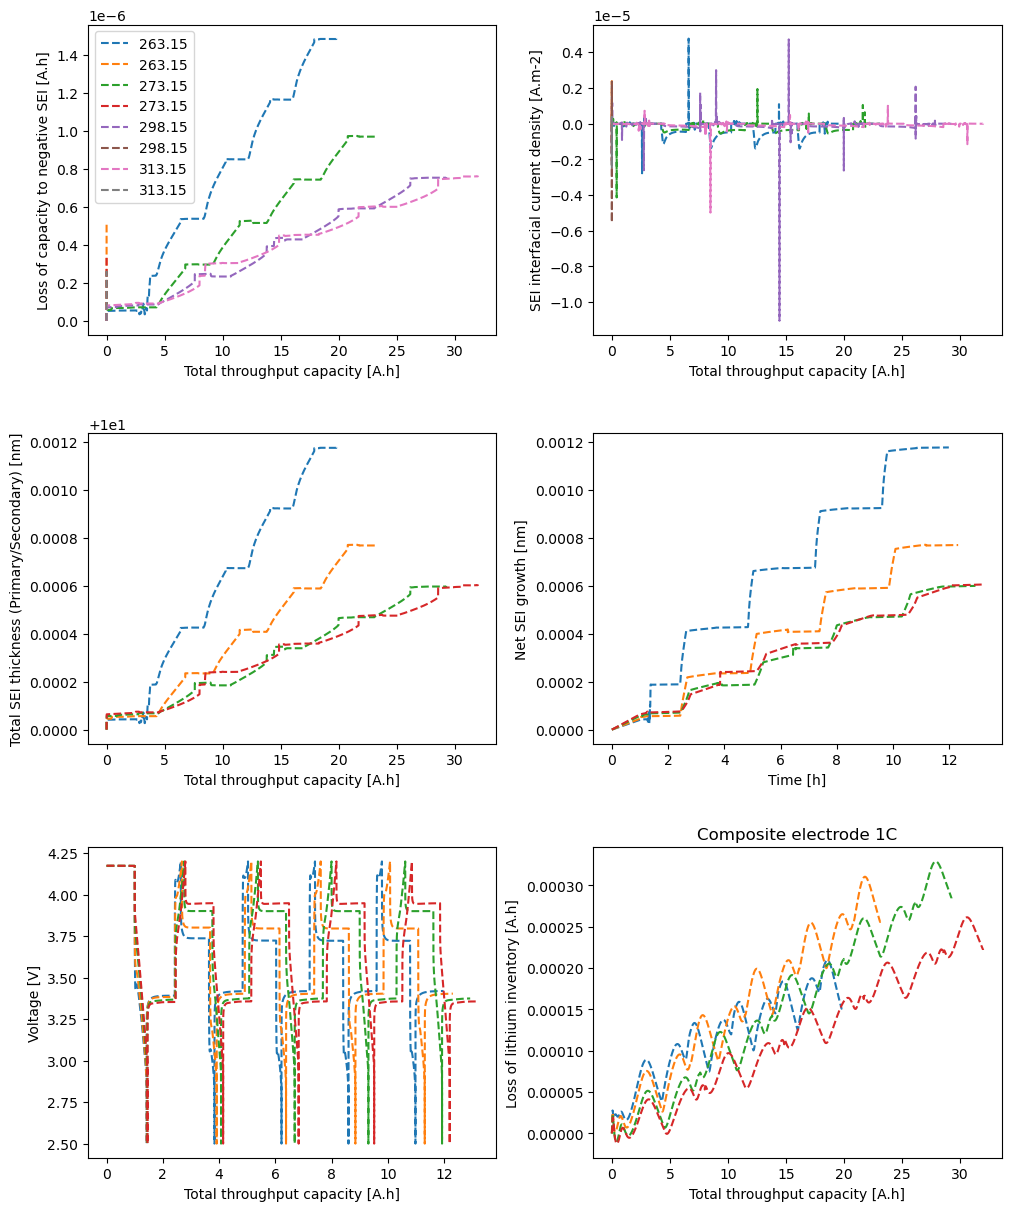

In [32]:
# plot results of temperature sweep
def plot_results(solution_set, variables):
    '''
    plot graph of SEI thickness, Capacity loss and Voltage against total throughput

        solution_set = list of solutions after solving multiple models
        variables = variables changed during parametric sweep
    
    '''

    fig, axes = plt.subplots(3,2, layout="constrained", figsize=(10,12), gridspec_kw={"hspace": 0.1}, sharex=False)
    plt.title("Composite electrode 1C")

    for index, sol in enumerate(solution_set):
        # independent variable
        Q_tot = sol["Throughput capacity [A.h]"].entries
        t = sol["Time [h]"].entries

        # various dependent variables
        Q_SEI = sol["Loss of capacity to negative SEI [A.h]"].entries
        Q_SEI_1 = sol["Loss of capacity to negative primary SEI [A.h]"].entries
        Q_SEI_2 = sol["Loss of capacity to negative secondary SEI [A.h]"].entries

        # current densities
        J_SEI_1 = sol["X-averaged negative electrode primary SEI interfacial current density [A.m-2]"].entries
        J_SEI_2 = sol["X-averaged negative electrode secondary SEI interfacial current density [A.m-2]"].entries
        J_SEI = (J_SEI_1 + J_SEI_2)
        

        V_i = sol["Voltage [V]"].entries
        # electrolyte_V = sol["Electrolyte potential [V]"].entries
        # C_dis = sol["Discharge capacity [A.h]"].entries
        
        # LLI
        Q_LLI = sol["Total lithium lost [mol]"].entries #*96485.3 / 3600
        
        # SEI thickness of composite phases
        L_SEI_1 = (sol["X-averaged negative total primary SEI thickness [m]"].entries)*1e9
        L_SEI_2 = (sol["X-averaged negative total secondary SEI thickness [m]"].entries)*1e9
        L_SEI = (L_SEI_1 + L_SEI_2)
        L_min = np.min(L_SEI)
        delta_L = (L_SEI - L_min)

        # plot graph on the go

        axes[0][0].plot(Q_tot, Q_SEI, Q_SEI_1, Q_SEI_2, label=f"{variables[index]}", linestyle="--")
        axes[0][1].plot(Q_tot, J_SEI, J_SEI_1, J_SEI_2, label=f"{variables[index]}", linestyle="--")
        axes[1][0].plot(Q_tot, L_SEI, label=f"{variables[index]}", linestyle="--")
        axes[1][1].plot(t, delta_L, label=f"{variables[index]}", linestyle="--")
        axes[2][0].plot(t, V_i, label=f"{variables[index]}", linestyle="--")
        axes[2][1].plot(Q_tot, Q_LLI, label=f"{variables[index]}", linestyle="--")
        
    # graph formatting
    # Primary on the left, secondary on the right?
    axes[0][0].set_xlabel("Total throughput capacity [A.h]")
    axes[0][0].set_ylabel("Loss of capacity to negative SEI [A.h]") 
    axes[0][0].legend()
    
    axes[0][1].set_xlabel("Total throughput capacity [A.h]")
    axes[0][1].set_ylabel("SEI interfacial current density [A.m-2]")

    axes[1][0].set_xlabel("Total throughput capacity [A.h]")
    axes[1][0].set_ylabel("Total SEI thickness (Primary/Secondary) [nm]")


    axes[1][1].set_xlabel("Time [h]")
    axes[1][1].set_ylabel("Net SEI growth [nm]")

    axes[2][0].set_xlabel("Total throughput capacity [A.h]")
    axes[2][0].set_ylabel("Voltage [V]")

    axes[2][1].set_xlabel("Total throughput capacity [A.h]")
    axes[2][1].set_ylabel("Loss of lithium inventory [A.h]")


plot_results(temp_sols, temps)